In [1]:
%matplotlib inline
from pyqubo import Array, Placeholder, solve_qubo, Constraint, Sum
import matplotlib.pyplot as plt
import networkx as nx

## グラフ彩色問題

グラフ$G=(V,E)$と色数$K$が与えられたとき、グラフの頂点を$K$色で塗り分ける (彩色する)。このとき、隣接する頂点 (すなわち、辺で接続されている頂点) は同色にならないという制約下での彩色方法を見つけたい。
この問題はQUBOにより次のように定式化される。

\begin{eqnarray*}
H &=& \alpha H_{A} + H_{B} \\
H_{A} &=& \sum_{i \in V} \left( 1 - \sum_{k = 1}^{K} x_{i,k}\right )^2 \\
H_{B} &=& \sum_{(i, j) \in E} \sum_{k = 1}^{K} x_{i,k} x_{j,k}
\end{eqnarray*}

$H_{A}$は1つの頂点はただ1色に対応する制約を表す。$V$内のすべての頂点に対し、頂点が対応する$K$個のバイナリ変数のうち1個だけが1で残りがすべて0のときに$H_{A}=0$となり最小となる。

$H_{B}$は隣接する頂点は別色に彩色されるという制約を表す。すべての隣接する頂点ペア (すなわち、$E$内のすべての辺) に対し、同色の隣接が存在しないときに$H_{B}=0$となり最小となる。

$\alpha$は制約の強さを調整するパラメータである。

In [2]:
def plot_graph(N, E, colors=None):
    G = nx.Graph()
    G.add_nodes_from([n for n in range(N)])
    for (i, j) in E:
        G.add_edge(i, j)
    plt.figure(figsize=(4,4))
    pos = nx.circular_layout(G)
    colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']
    if colors:
        nx.draw_networkx(G, pos, node_color=[colorlist[colors[node]] for node in G.nodes], node_size=400, font_weight='bold', font_color='w')
    else:
        nx.draw_networkx(G, pos, node_color=[colorlist[0] for _ in G.nodes], node_size=400, font_weight='bold', font_color='w')
    plt.axis("off")
    plt.show()

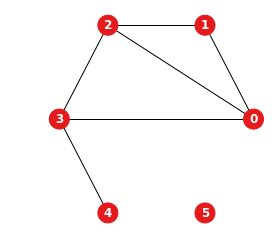

In [3]:
# 頂点数と色数
N = 6
K = 3

# エッジが以下のように与えられる
E = {(0, 1), (0, 2), (0, 3), (1, 2), (2, 3), (3, 4)}
plot_graph(N, E)

頂点数 $\times$ 色数 $= 6 \times 3$次元のバイナリベクトル$x$を用意。$x[i, k]=1$は頂点$i$が色$k$に彩色されていることを表現している (one-hot encoding)。

In [4]:
x = Array.create('x', (N, K), 'BINARY')

In [5]:
# ある頂点iが1色のみである制約
onecolor_const = 0.0
for i in range(N):
    onecolor_const += Constraint((Sum(0, K, lambda j: x[i, j]) - 1)**2, label="onecolor{}".format(i))

In [6]:
# 隣接頂点は異色で塗り分けられるという制約
adjacent_const = 0.0
for (i, j) in E:
    for k in range(K):
        adjacent_const += Constraint(x[i, k] * x[j, k], label="adjacent({},{})".format(i, j))

In [7]:
# エネルギー (ハミルトニアン) を構築
alpha = Placeholder("alpha")
H = alpha * onecolor_const + adjacent_const

In [8]:
# モデルをコンパイル
model = H.compile()

# QUBOを作成
feed_dict = {'alpha': 1.0}
qubo, offset = model.to_qubo(feed_dict=feed_dict)

In [9]:
# 最適解を求める
solution = solve_qubo(qubo)

decoded_solution, broken, energy = model.decode_solution(solution, vartype="BINARY", feed_dict=feed_dict)
print("number of broken constarint = {}".format(len(broken)))

# 各頂点の色を取得する
colors = [0 for i in range(N)]
for i in range(N):
    for k in range(K):
        if decoded_solution['x'][i][k] == 1:
            colors[i] = k
            break

number of broken constarint = 0


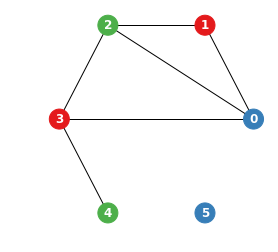

In [10]:
# 彩色後のグラフを表示
plot_graph(N, E, colors)